<a href="https://colab.research.google.com/github/lorenzosteccanella/HRL-MDP/blob/main/Example_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A simple example on how to learn a representation on the Nine Rooms environment

In [1]:
# only required to run this notebook on COLAB

!git clone https://github.com/lorenzosteccanella/HRL-MDP.git
%cd HRL-MDP/

# compared to requirements.txt we just avoid to reinstall torch, since it can take a while.
!pip install matplotlib==3.5.0
!pip install wandb==0.16.4
!pip install tqdm==4.66.2
!pip install gym==0.9.6
!pip install git+https://github.com/lorenzosteccanella/gym-minigrid.git

fatal: destination path 'HRL-MDP' already exists and is not an empty directory.
/content/HRL-MDP
  Cloning https://github.com/lorenzosteccanella/gym-minigrid.git to /tmp/pip-req-build-16i1zcxh
  Running command git clone --filter=blob:none --quiet https://github.com/lorenzosteccanella/gym-minigrid.git /tmp/pip-req-build-16i1zcxh
  Resolved https://github.com/lorenzosteccanella/gym-minigrid.git to commit 6b6293f05b473a3432336ff3ba132298dc5a9b12
  Preparing metadata (setup.py) ... done


In [2]:
# To supress old gym deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message='Parameters to load are deprecated.*')

import numpy as np
from utils import collect_trajectories, representation_score, wandb_plot
from model import SoftClusterNetwork
from torch import optim
import torch
import matplotlib.pyplot as plt

In [3]:
config = {
    "seed": 0,
    "env": "MiniGrid-NineRoomsDet-v0",
    "load_data": False,
    "p_random_action": 0,
    "max_len_episode": 100,
    "pos_or_image": "image",
    "n_episodes_env": 1000,
    "n_abstract_states": 9,
    "width": 19,
    "height": 19,
    "lr": 1e-4,
    "epochs": 1600,
    "batch_size": 32,
    "wl1": 1,
    "wl2": 0.4,
    "wl3": 0.1
}

In [4]:
import gdown
import pickle

def load_or_collect_data(config):
    """Load data from Drive or collect if download fails"""
    files = {
        'annotations': '1GATPNJVt7GTRmC-TgUL-gM3fJ7LkZ_2y',
        'dataset': '12OO55cevauiZULbCHgKHq139kf6EjUEU',
        'memory': '1bUrzv0wXUmUQojWn3SpTb6zfEhw_7mur',
        'dataset_states': '1w8cQdlp_SPVFCCHuksrslvcsZrbIQFfT'
    }

    try:
        # Try downloading and loading files
        for name, file_id in files.items():
            print(f'Downloading {name}...')
            try:
                gdown.download(f'https://drive.google.com/uc?id={file_id}', f'{name}.pkl', quiet=False)
            except Exception as e:
                print(f'Failed to download {name}: {str(e)}')
                raise

        # Load files
        print('Loading files...')
        with open('memory.pkl', 'rb') as f: memory = pickle.load(f)
        with open('dataset.pkl', 'rb') as f: trajectories_dataset = pickle.load(f)
        with open('dataset_states.pkl', 'rb') as f: print_states = pickle.load(f)
        with open('annotations.pkl', 'rb') as f: annotations = pickle.load(f)
        print('Successfully loaded from Drive!')

    except Exception as e:
        print(f'Drive download failed: {str(e)}')
        print('Collecting trajectories...')
        memory, trajectories_dataset, print_states, annotations = collect_trajectories(config)

    return memory, trajectories_dataset, print_states, annotations

# Usage
memory, trajectories_dataset, print_states, annotations = load_or_collect_data(config)


Downloading...
From: https://drive.google.com/uc?id=1GATPNJVt7GTRmC-TgUL-gM3fJ7LkZ_2y
To: /content/HRL-MDP/annotations.pkl
100%|██████████| 10.8k/10.8k [00:00<00:00, 20.4MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=12OO55cevauiZULbCHgKHq139kf6EjUEU
From (redirected): https://drive.google.com/uc?id=12OO55cevauiZULbCHgKHq139kf6EjUEU&confirm=t&uuid=045b9ac5-6b98-4716-8c30-59afd44527bb
To: /content/HRL-MDP/dataset.pkl
100%|██████████| 446M/446M [00:03<00:00, 127MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1bUrzv0wXUmUQojWn3SpTb6zfEhw_7mur
From (redirected): https://drive.google.com/uc?id=1bUrzv0wXUmUQojWn3SpTb6zfEhw_7mur&confirm=t&uuid=e286e21c-55fc-419b-8a0e-8bf0a63f7223
To: /content/HRL-MDP/memory.pkl
100%|██████████| 905M/905M [00:08<00:00, 107MB/s]


Downloading...
From: https://drive.google.com/uc?id=1w8cQdlp_SPVFCCHuksrslvcsZrbIQFfT
To: /content/HRL-MDP/dataset_states.pkl
100%|██████████| 1.04M/1.04M [00:00<00:00, 93.8MB/s]


Loading files...
Successfully loaded from Drive!


In [5]:
# set seed
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# # # Training the network
network = SoftClusterNetwork(config["n_abstract_states"], config["width"], config["height"])
optimizer = optim.Adam(network.parameters(), lr=config["lr"])


Epoch 0, Loss: (-0.6022342443466187, 0.07183152437210083, -2.1944663524627686, 2.037208080291748)
Error: 305.5761184370951, Squared Error: 420.67232978872266, Abs Error: 442.80563466995955


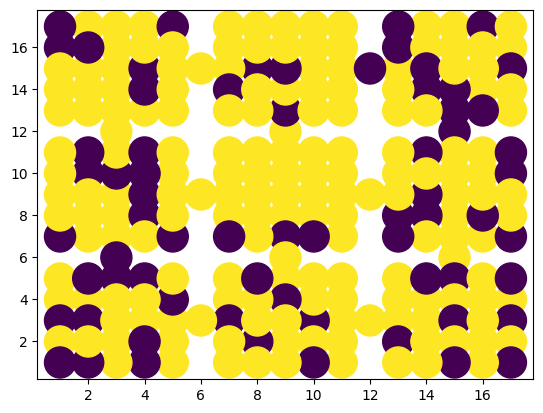

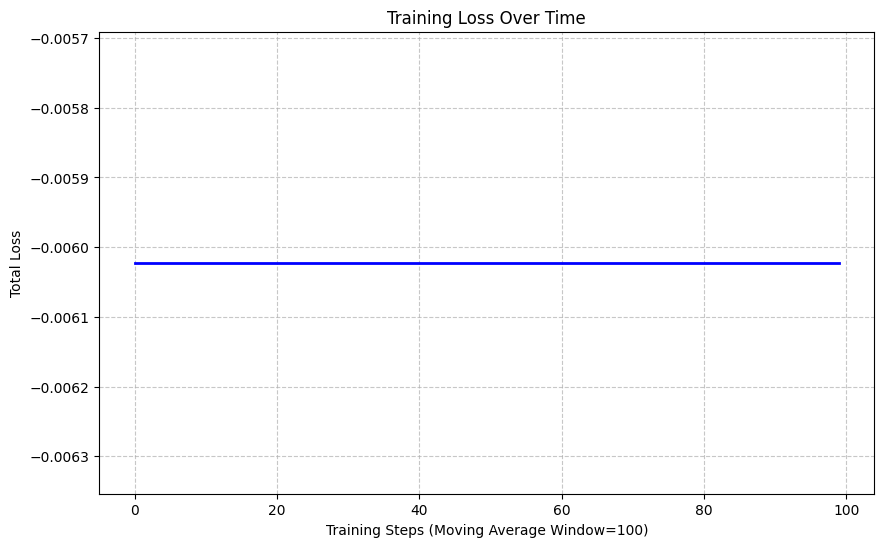

Epoch 100, Loss: (-0.7939531803131104, 0.027310822159051895, -2.1744544506073, 0.485177606344223)
Error: 169.33108321755344, Squared Error: 208.43588820908124, Abs Error: 251.71357028197963


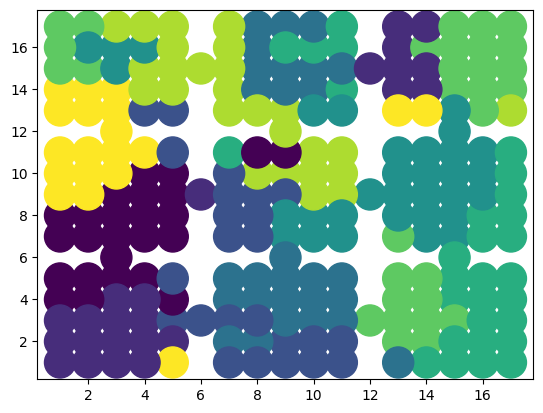

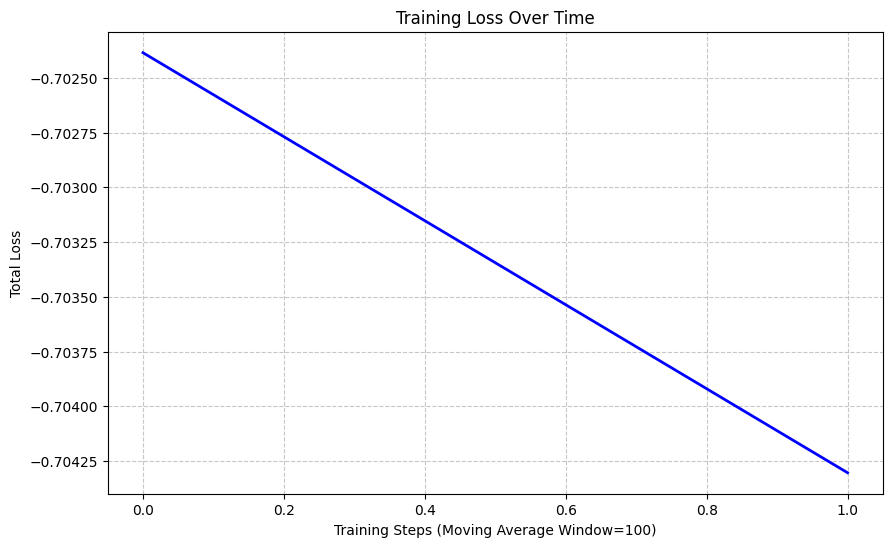

Epoch 200, Loss: (-0.7993040680885315, 0.02948133274912834, -2.162714958190918, 0.3630058169364929)
Error: 150.98254119089367, Squared Error: 195.41703392349186, Abs Error: 219.15647328122577


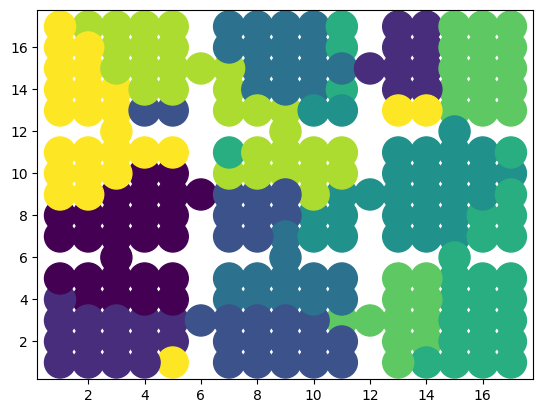

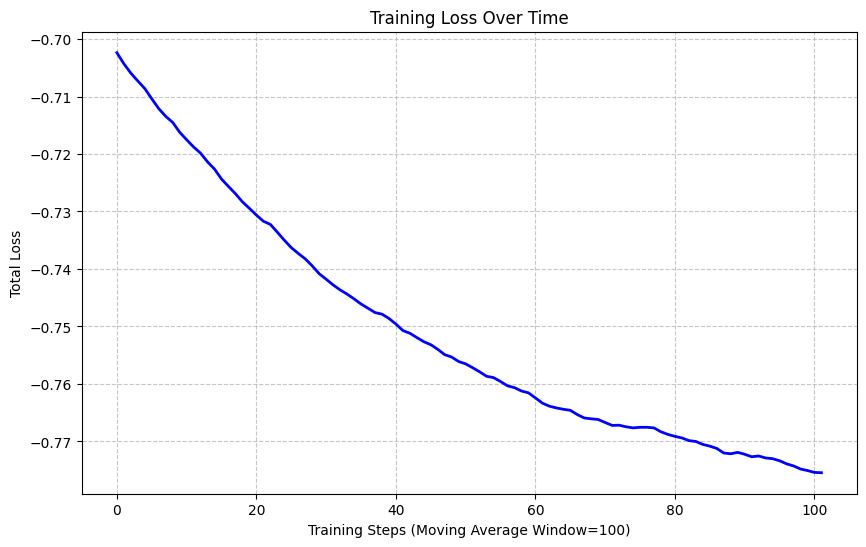

Epoch 300, Loss: (-0.8149644732475281, 0.02092006616294384, -2.146108627319336, 0.22558942437171936)
Error: 145.62349765853696, Squared Error: 193.03563834487935, Abs Error: 209.41000501884264


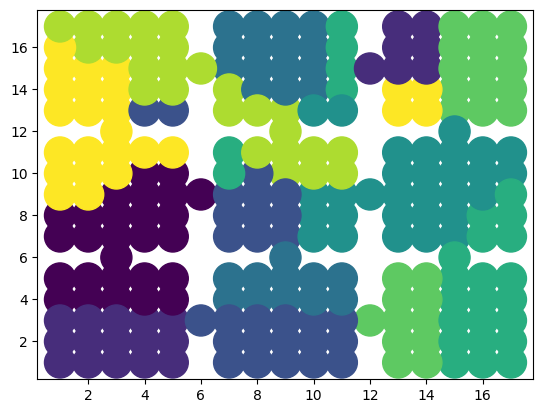

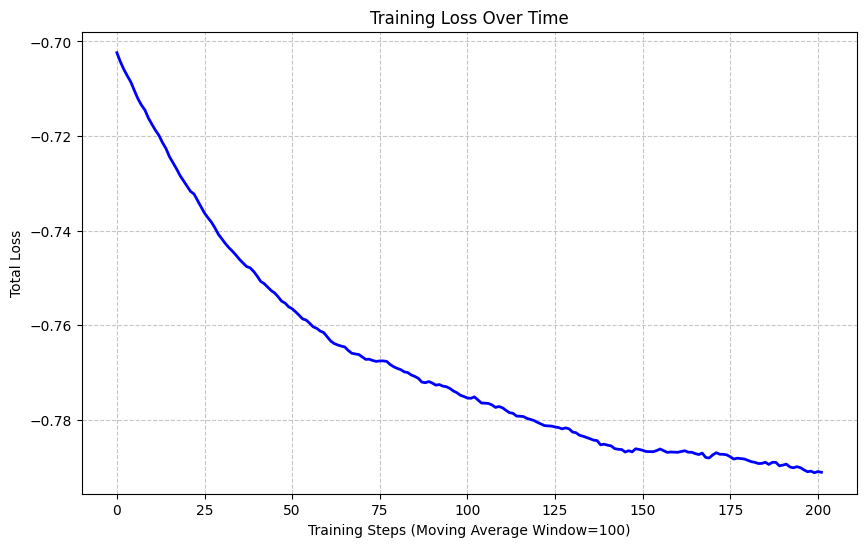

Epoch 400, Loss: (-0.8185275197029114, 0.019891293719410896, -2.148998260498047, 0.21180422604084015)
Error: 139.15967420182986, Squared Error: 184.22838488691627, Abs Error: 199.0267253801212


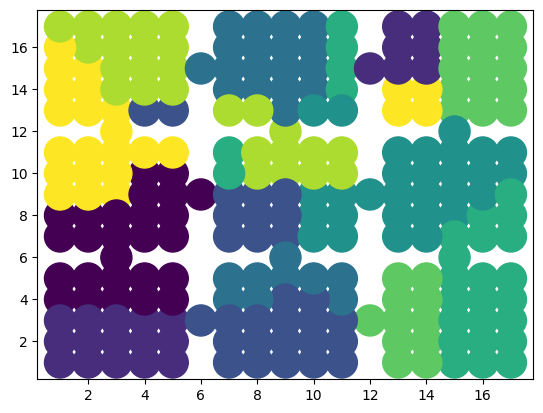

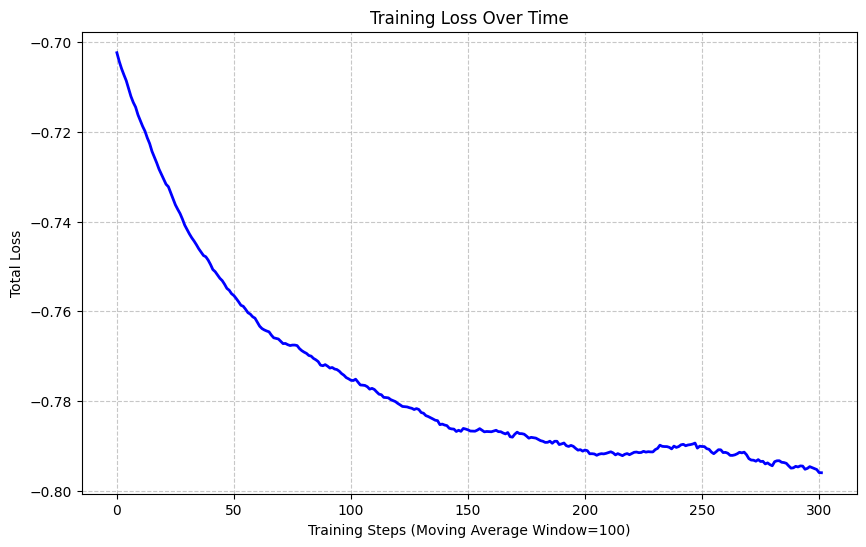

Epoch 500, Loss: (-0.8064738512039185, 0.012886131182312965, -2.096998929977417, 0.19439662992954254)
Error: 112.83253345707563, Squared Error: 145.20987836252098, Abs Error: 162.2772615121903


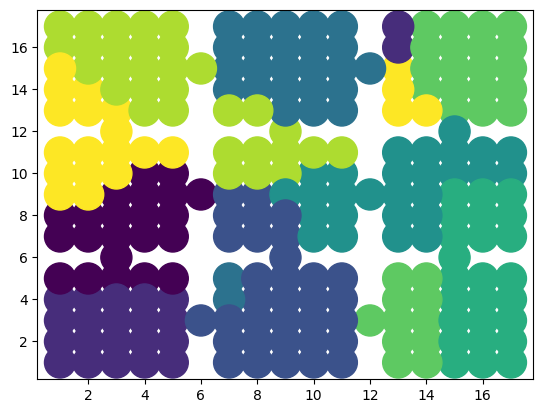

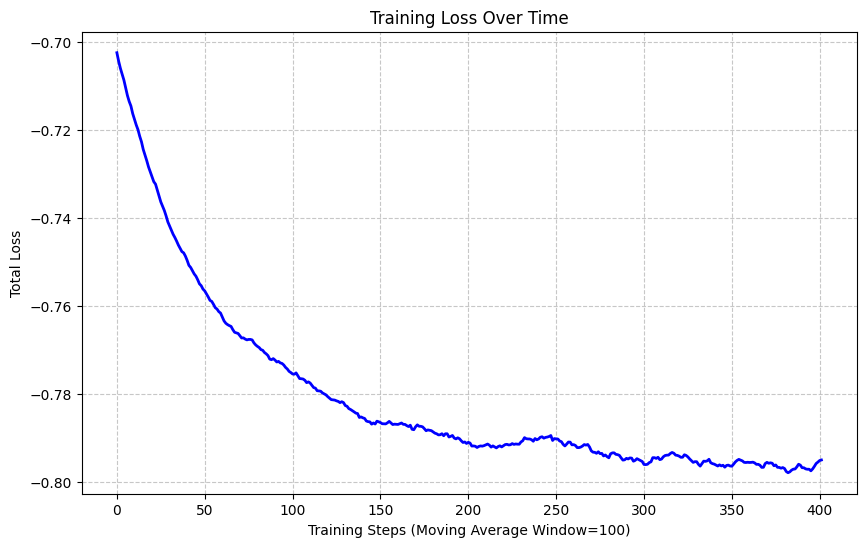

Epoch 600, Loss: (-0.8141392469406128, 0.016961781308054924, -2.1307125091552734, 0.21184049546718597)
Error: 88.64096630044021, Squared Error: 112.16797353879424, Abs Error: 127.75834822918114


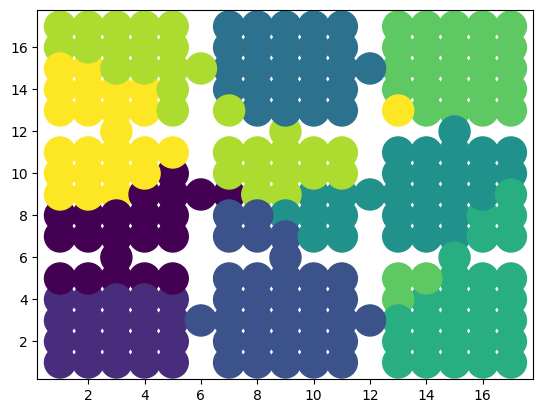

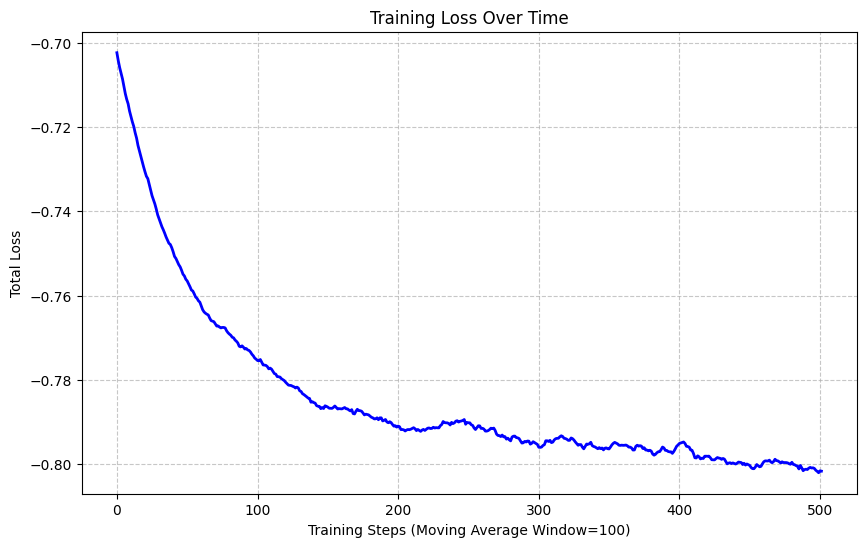

Epoch 700, Loss: (-0.823787271976471, 0.010329155251383781, -2.133958101272583, 0.19466879963874817)
Error: 49.234963431057906, Squared Error: 59.08865479931765, Abs Error: 71.55175900489667


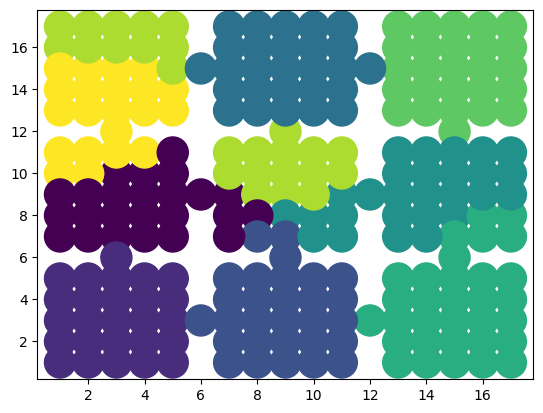

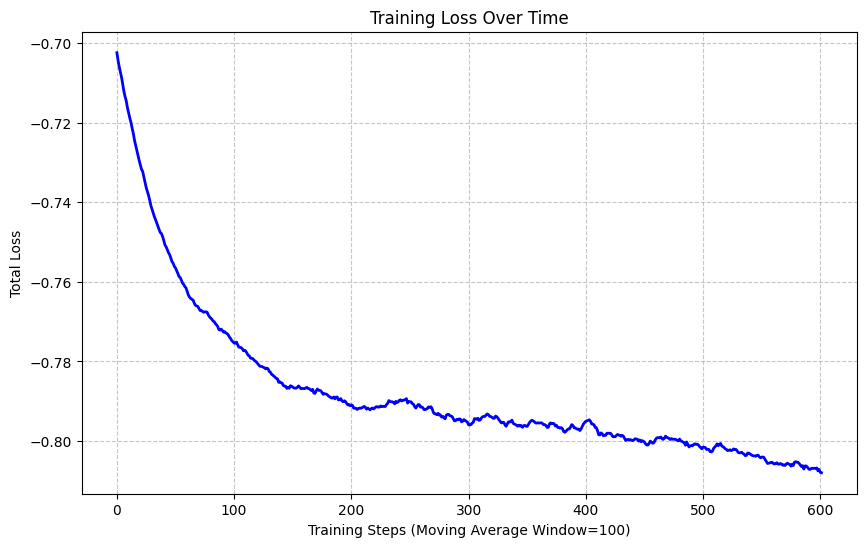

Epoch 800, Loss: (-0.8193624019622803, 0.0075767613016068935, -2.0913565158843994, 0.096034474670887)
Error: 39.602485363990034, Squared Error: 48.29430182680984, Abs Error: 56.90688642760415


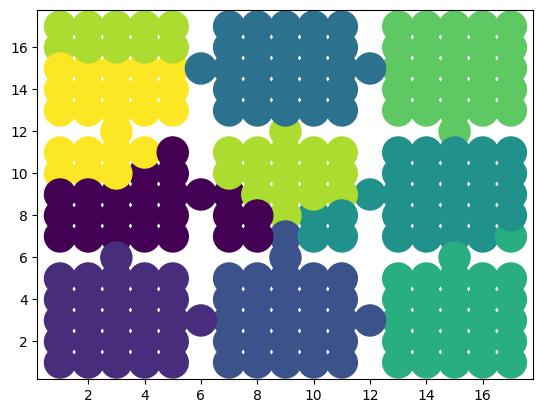

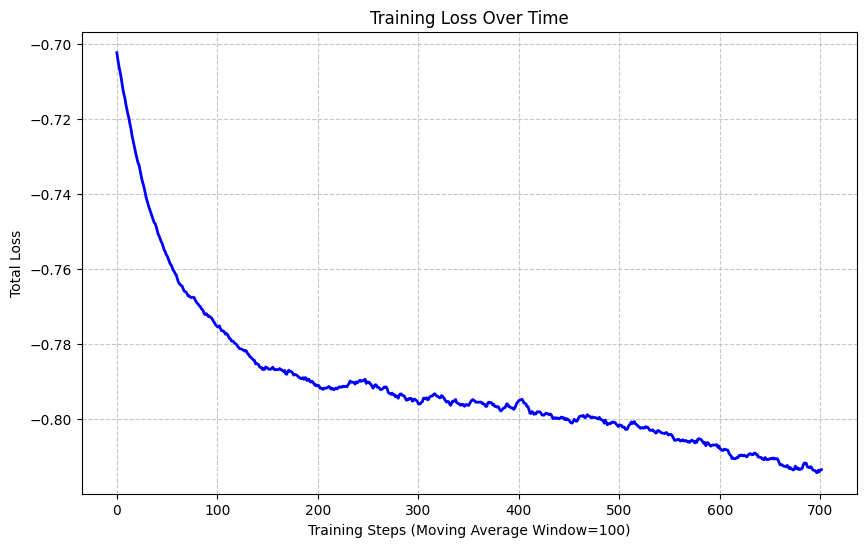

Epoch 900, Loss: (-0.8097752332687378, 0.005614673253148794, -2.062507152557373, 0.0961291566491127)
Error: 34.67701989855262, Squared Error: 41.77391087944792, Abs Error: 50.08458535831869


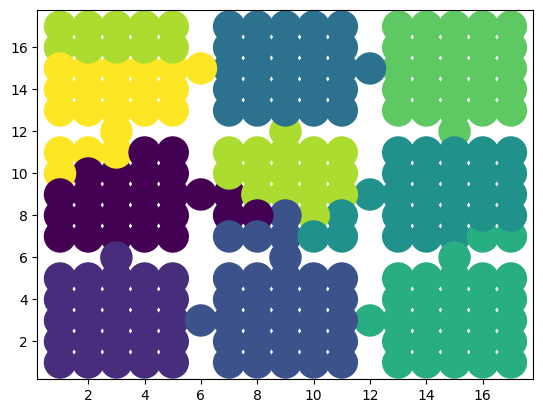

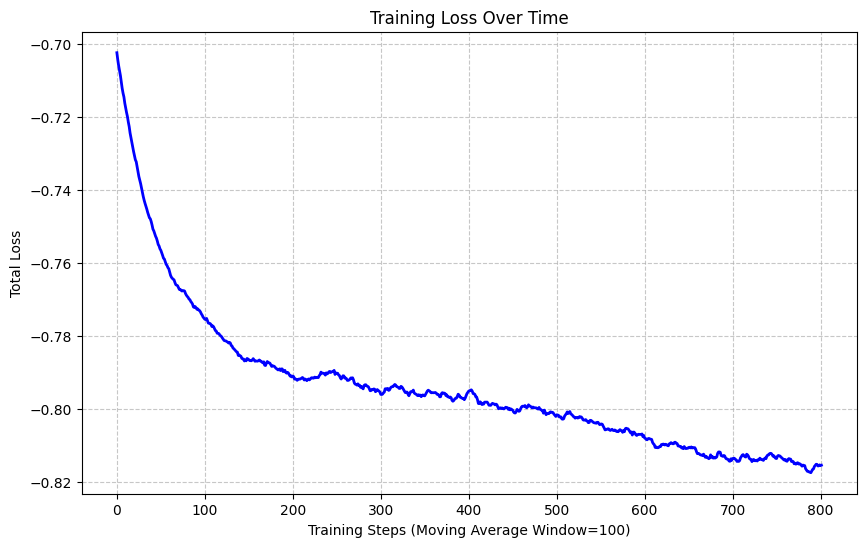

Epoch 1000, Loss: (-0.8062770366668701, 0.008252493105828762, -2.057222843170166, 0.08359605818986893)
Error: 12.392535398318051, Squared Error: 11.43313076482423, Abs Error: 17.99677393366437


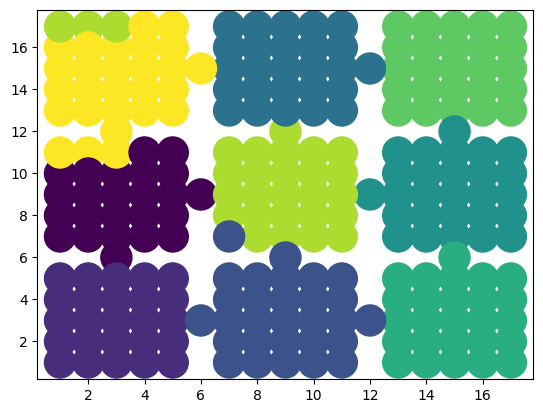

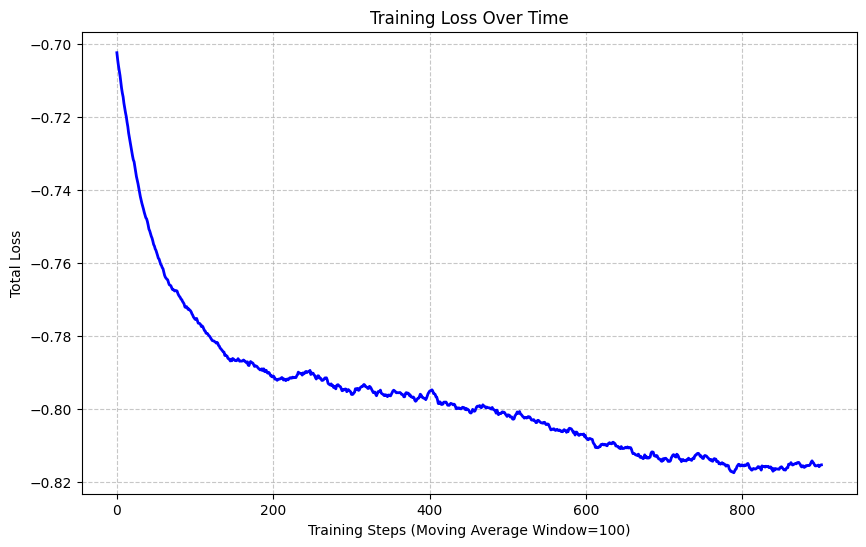

Epoch 1100, Loss: (-0.8126332759857178, 0.003862557467073202, -2.061497211456299, 0.08103056252002716)
Error: 2.8542894132254517, Squared Error: 0.6626249278212248, Abs Error: 4.29864673419047


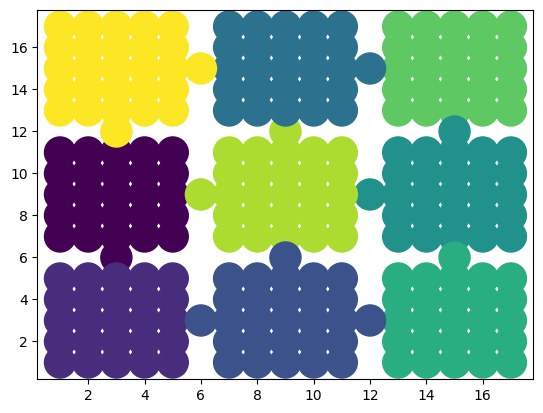

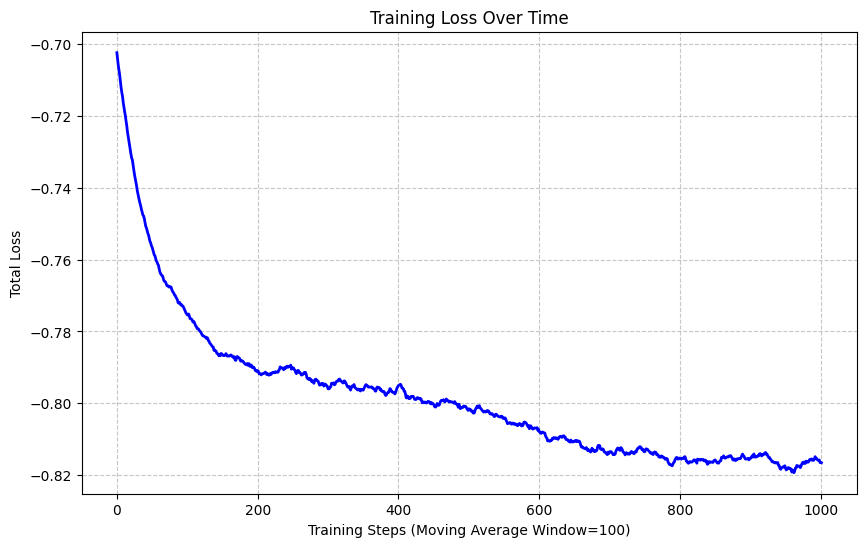

Epoch 1200, Loss: (-0.8109639286994934, 0.014166462235152721, -2.0856895446777344, 0.09145434945821762)
Error: 2.5389076830844566, Squared Error: 0.9377589585310029, Abs Error: 3.8200968537703375


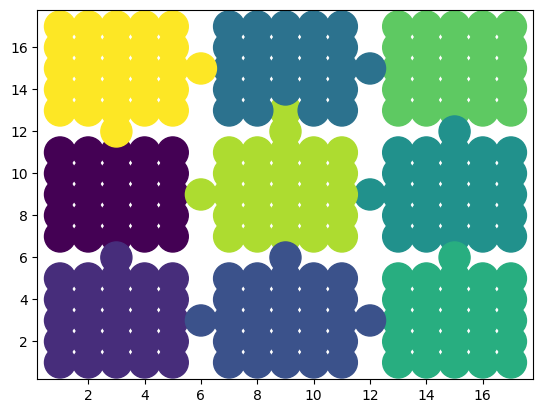

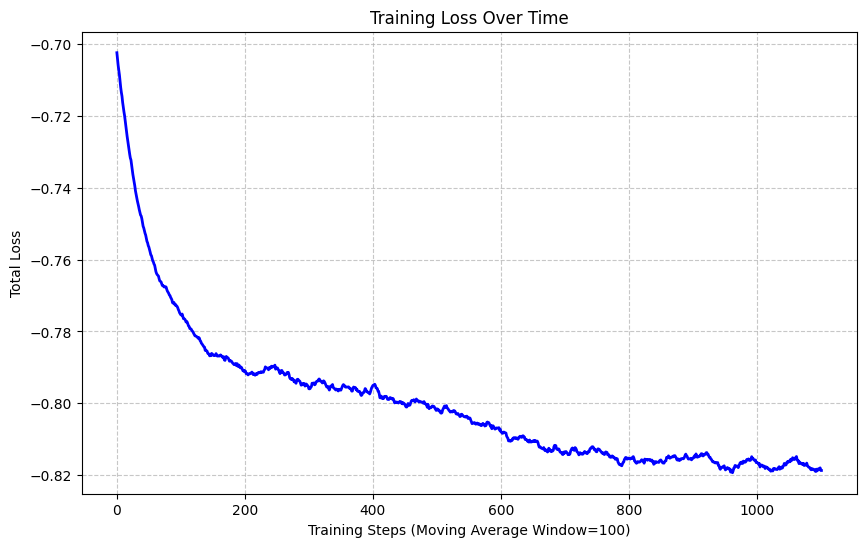

Epoch 1300, Loss: (-0.8143815398216248, 0.0038173531647771597, -2.0618045330047607, 0.06522911041975021)
Error: 3.9888075985698745, Squared Error: 2.6791361804885088, Abs Error: 5.831320688849701


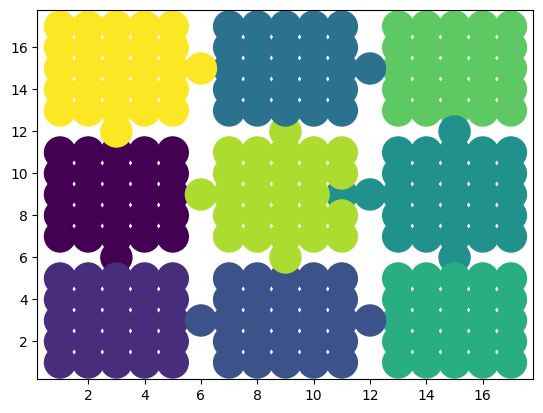

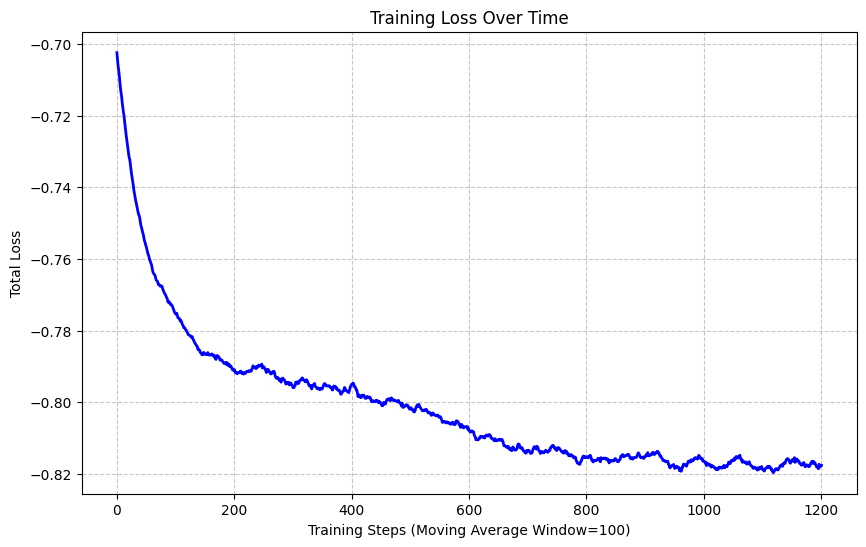

Epoch 1400, Loss: (-0.8386794924736023, 0.0031338955741375685, -2.1196351051330566, 0.06040685623884201)
Error: 1.3084219137653919, Squared Error: 0.23520464914578493, Abs Error: 1.9894956065045335


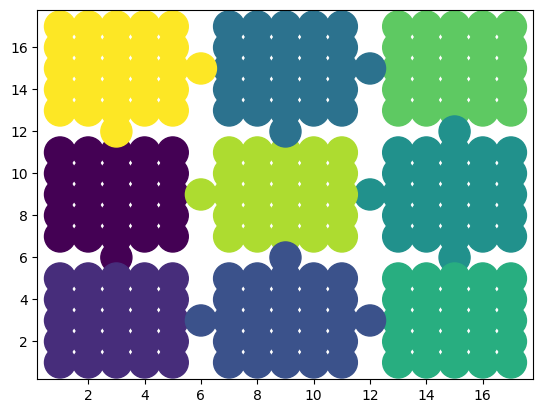

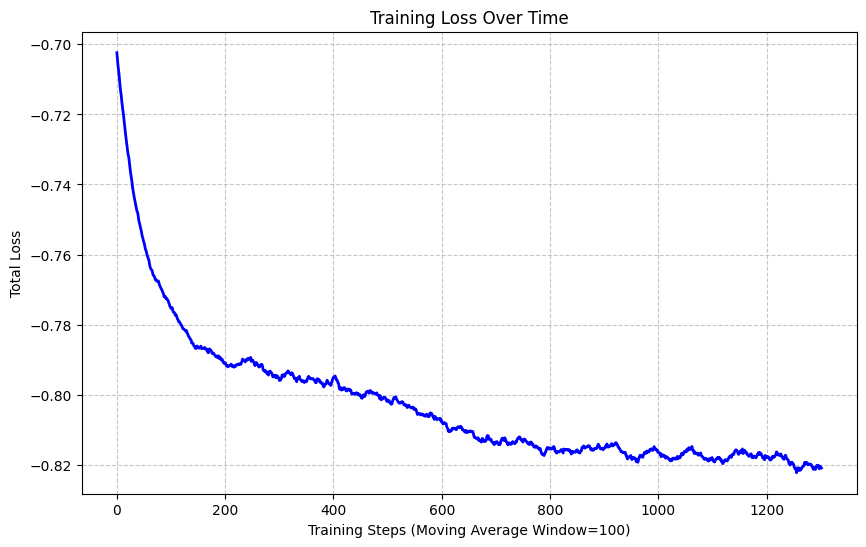

Epoch 1500, Loss: (-0.798018217086792, 0.0050715128891170025, -2.0179924964904785, 0.041073039174079895)
Error: 0.6350700037722982, Squared Error: 0.014401989865504837, Abs Error: 1.0119032432876338


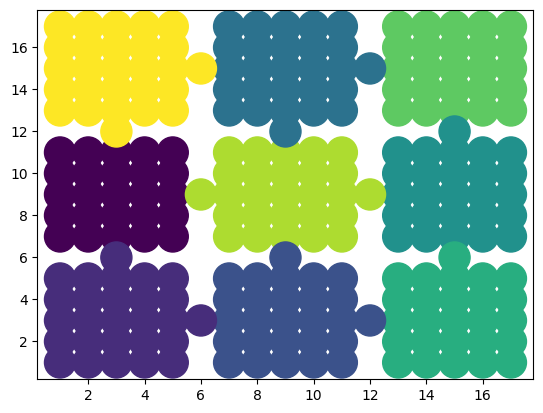

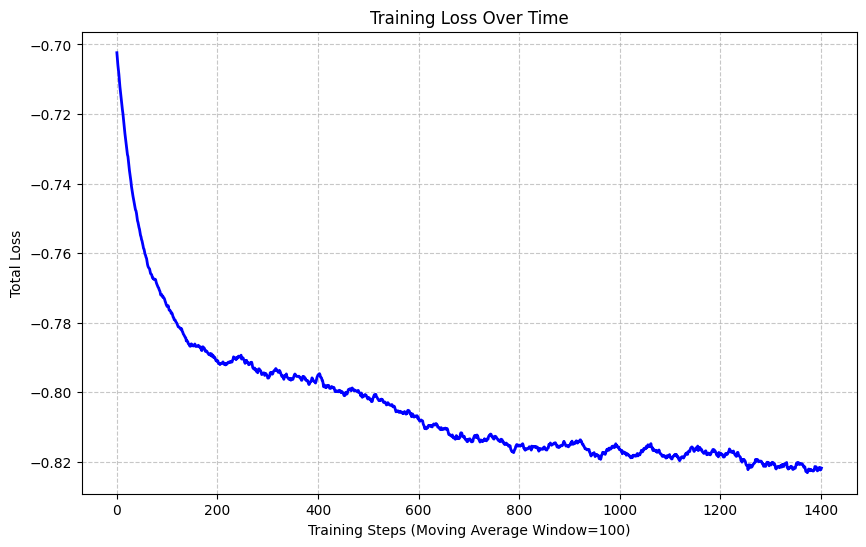

In [6]:
losses = []
for i in range(config["epochs"]):
    network.train()
    idx, batch_x1, batch_x2, b_is_weights = memory.sample(config["batch_size"])
    x1 = torch.stack(batch_x1)
    x2 = torch.stack(batch_x2)
    z1 = network.pred(x1, 1)
    z2 = network.pred(x2, 1)
    compression_loss = ((-(z1 * z2.log())).sum(axis=1)).mean(axis=0)
    compression_loss = compression_loss / config["batch_size"]
    entropy_loss = (z1.mean(dim=0) * (z1.mean(dim=0).log())).sum()
    det_entropy_loss = (- (z1 * z1.log()).sum(dim=1)).mean()
    loss = config["wl1"] * compression_loss + config["wl2"] * entropy_loss + config["wl3"] * det_entropy_loss
    losses.append(loss.item())

    if i % 100 == 0:
        print(f"Epoch {i}, Loss: {loss.item(), compression_loss.item(), entropy_loss.item(), det_entropy_loss.item()}")
        error, squared_error, abs_error = representation_score(config, network.eval())
        print(f"Error: {error}, Squared Error: {squared_error}, Abs Error: {abs_error}")
        fig = wandb_plot(print_states, annotations, network.eval(), d=2)
        # Draw figure on canvas
        fig.canvas.draw()
        plt.show()

        # Create a new figure for losses
        plt.figure(figsize=(10, 6))
        # moving windows on the losses
        losses_to_plot = np.convolve(losses, np.ones(100)/100, mode='valid')
        # plot the losses graph with labels and title
        plt.plot(losses_to_plot, color='blue', linewidth=2)
        plt.xlabel('Training Steps (Moving Average Window=100)')
        plt.ylabel('Total Loss')
        plt.title('Training Loss Over Time')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    optimizer.zero_grad()
    loss.backward()
    # Replace gradient clamping with norm clipping
    torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=0.1)
    optimizer.step()